# GARCH Modelleri İle Volatilite Modellemesi

Ancak, ARIMA (Otoregresif Entegre Hareketli Ortalama) gibi modeller, zaman içinde sabit olmayan oynaklığı (heteroskedastik) açıklayamaz. Bazı dönüşümlerin (log veya Box-Cox dönüşümleri gibi) volatilitedeki mütevazı değişiklikleri ayarlamak için kullanılabileceğini zaten açıklamıştık, ancak bir adım daha ileri gitmek ve modellemek istiyoruz.

Volatilitedeki bir artış, volatilitedeki daha fazla bir artış ile ilişkili olduğunda ortaya çıkan bir olgu olan koşullu heteroskedastisiteye odaklanacağız. Bir örnek, bu kavramı anlamaya yardımcı olabilir. Şirketle ilgili bazı son dakika haberleri nedeniyle bir varlığın fiyatının önemli ölçüde düştüğünü düşünün. Bu tür ani bir fiyat düşüşü, önceki fiyat düşüşünün bir sonucu olarak hisse senetlerini satmaya başlayan yatırım fonlarının bazı risk yönetim araçlarını tetikleyebilir. Bu, fiyatın daha da düşmesine neden olabilir. Koşullu heteroskedastisite, getirilerin volatilite kümelenmesi sergilediğini gösterdiğimiz varlık getirileri uygulamasının stilize edilmiş gerçeklerinin araştırılmasında da açıkça görülmüştü.

Oynaklık finans alanında inanılmaz derecede önemli bir kavramdır. Risk ile eş anlamlıdır ve nicel finansta birçok uygulaması vardır. İlk olarak, Black-Scholes modeli sözkonusu varlığın oynaklığına dayandığından opsiyon fiyatlandırmasında kullanılır. İkinci olarak, oynaklığın risk yönetimi üzerinde önemli bir etkisi vardır; burada bir portföyün Riske Maruz Değer (VaR), Sharpe oranı ve daha fazlası gibi metrikleri hesaplamak için kullanılır. Üçüncüsü, doğrudan CBOE Volatilite Endeksi (ticker sembolü: VIX) biçiminde alınıp satılabildiğinden, volatilite ticarette de mevcuttur. İsmi, dizinin gerçek zamanlı olarak hesaplandığı Chicago Board Options Exchange'den gelir.

Burada ele alınacak başlıklar aşağıdaki gibi olacaktır:

* Stok getirilerinin volatilitesinin ARCH modelleriyle açıklanması.
* Stok getirilerinin volatilitesinin GARCH modelleriyle açıklanması.
* Çok değişkenli volatilite tahmini için CCC-GARCH uygulaması.
* Şartlı kovaryans matrisinin DCC-GARCH ile tahmini.  

# 1. ARCH Modelleriyle Stok Getirilerinin Volatilitesinin Açıklanması

Burada, hisse senedi getirilerinin koşullu oynaklığı **Otoregresif Koşullu Değişen Varyans (ARCH)** modeliyle açıklanacaktır.

ARCH yönteminin mantığı aşağıdaki denklemlerle gösterilebilir:

$$\begin{array}{c}
r_{t}=\mu+\epsilon_{t} \\
\epsilon_{t}=\sigma_{t} z_{t} \\
\sigma_{t}^{2}=\omega+\sum_{i=1}^{q} \alpha_{i} \epsilon_{t-i}^{2}
\end{array}$$

İlk denklem, beklenen dönüş μ ve beklenmeyen getiri $\epsilon_{t}$'nin bir kombinasyonu olarak getiri serisini temsil eder. Sonuncusu aynı zamanda ortalama düzeltilmiş getiri, hata terimi veya yenilikler olarak da bilinir. $\epsilon_{t}$ beyaz gürültü özelliklerine sahiptir — koşullu ortalama sıfıra eşit ve zamanla değişen koşullu varyans $\sigma_{t}^{2}$ dir. Hata terimleri seri olarak ilişkisizdir, ancak koşullu değişen varyans özelliği gösterebildikleri için seri olarak bağımsız olmaları gerekmez.

Sıfır ortalama süreci, getirilerin sadece artıklar, $r_{t}=\epsilon_{t}$, tarafından tanımlandığını gösterir. Diğer popüler seçenekler arasında sabit ortalama $r_{t}=\mu+\epsilon_{v}$, otoregresif ortalama, ARMA vb özellikler gösterir.

İkinci denklemde, hata serisini, kalıntıların tipik boyutunu yöneten stokastik bir bileşen $z_{t} \sim N(0,1)$ ve koşullu standart sapma $\sigma_{t}$ cinsinden temsil ediyoruz. Stokastik bileşen standartlaştırılmış artıklar olarak da yorumlanabilir.

Üçüncü denklem ARCH formülünü gösterir, burada $\omega>0$ ve $\alpha_{i} \geq 0$.

ARCH modelinde önemli noktalar:

* ARCH modeli, zaman serisinin koşulsuz ve koşullu varyansı arasındaki farkı açıkça tanır.
* Koşullu varyansı, ortalama bir işlemden geçmiş artıkların (hataların) bir fonksiyonu olarak modeller.
* Koşulsuz varyansın zaman içinde sabit olduğunu varsayar.
* Otoregresif modele benzer şekilde modelde önceki kalıntı sayısını (q) belirtmeliyiz.
* ARCH modelleri, sadece belirtilen zaman serisine başka bir model (ARIMA gibi) uygulandıktan sonra elde edilen artıklara uygulanmalıdır.
* Kalıntılar, ayrı bir beyaz gürültü-sıfır ortalaması, durağan (trendler veya mevsimsel etkiler, yani belirgin bir seri korelasyon yok) gözlemleri gibi görünmelidir.

Burada Google'ın 2015-2018 yılları arasındaki günlük stok fiyatları için ARCH(1) modeli uygulanacaktır.

Kütüphanelerin çaağırılması:

In [15]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

Varlık ve zaman periyodunun belirlenmesi:

In [16]:
RISKY_ASSET = 'GOOG'
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

Verinin Yahoo'dan çekilmesi:

In [17]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

[*********************100%***********************]  1 of 1 completed


Günlük getirilerin hesaplanması:

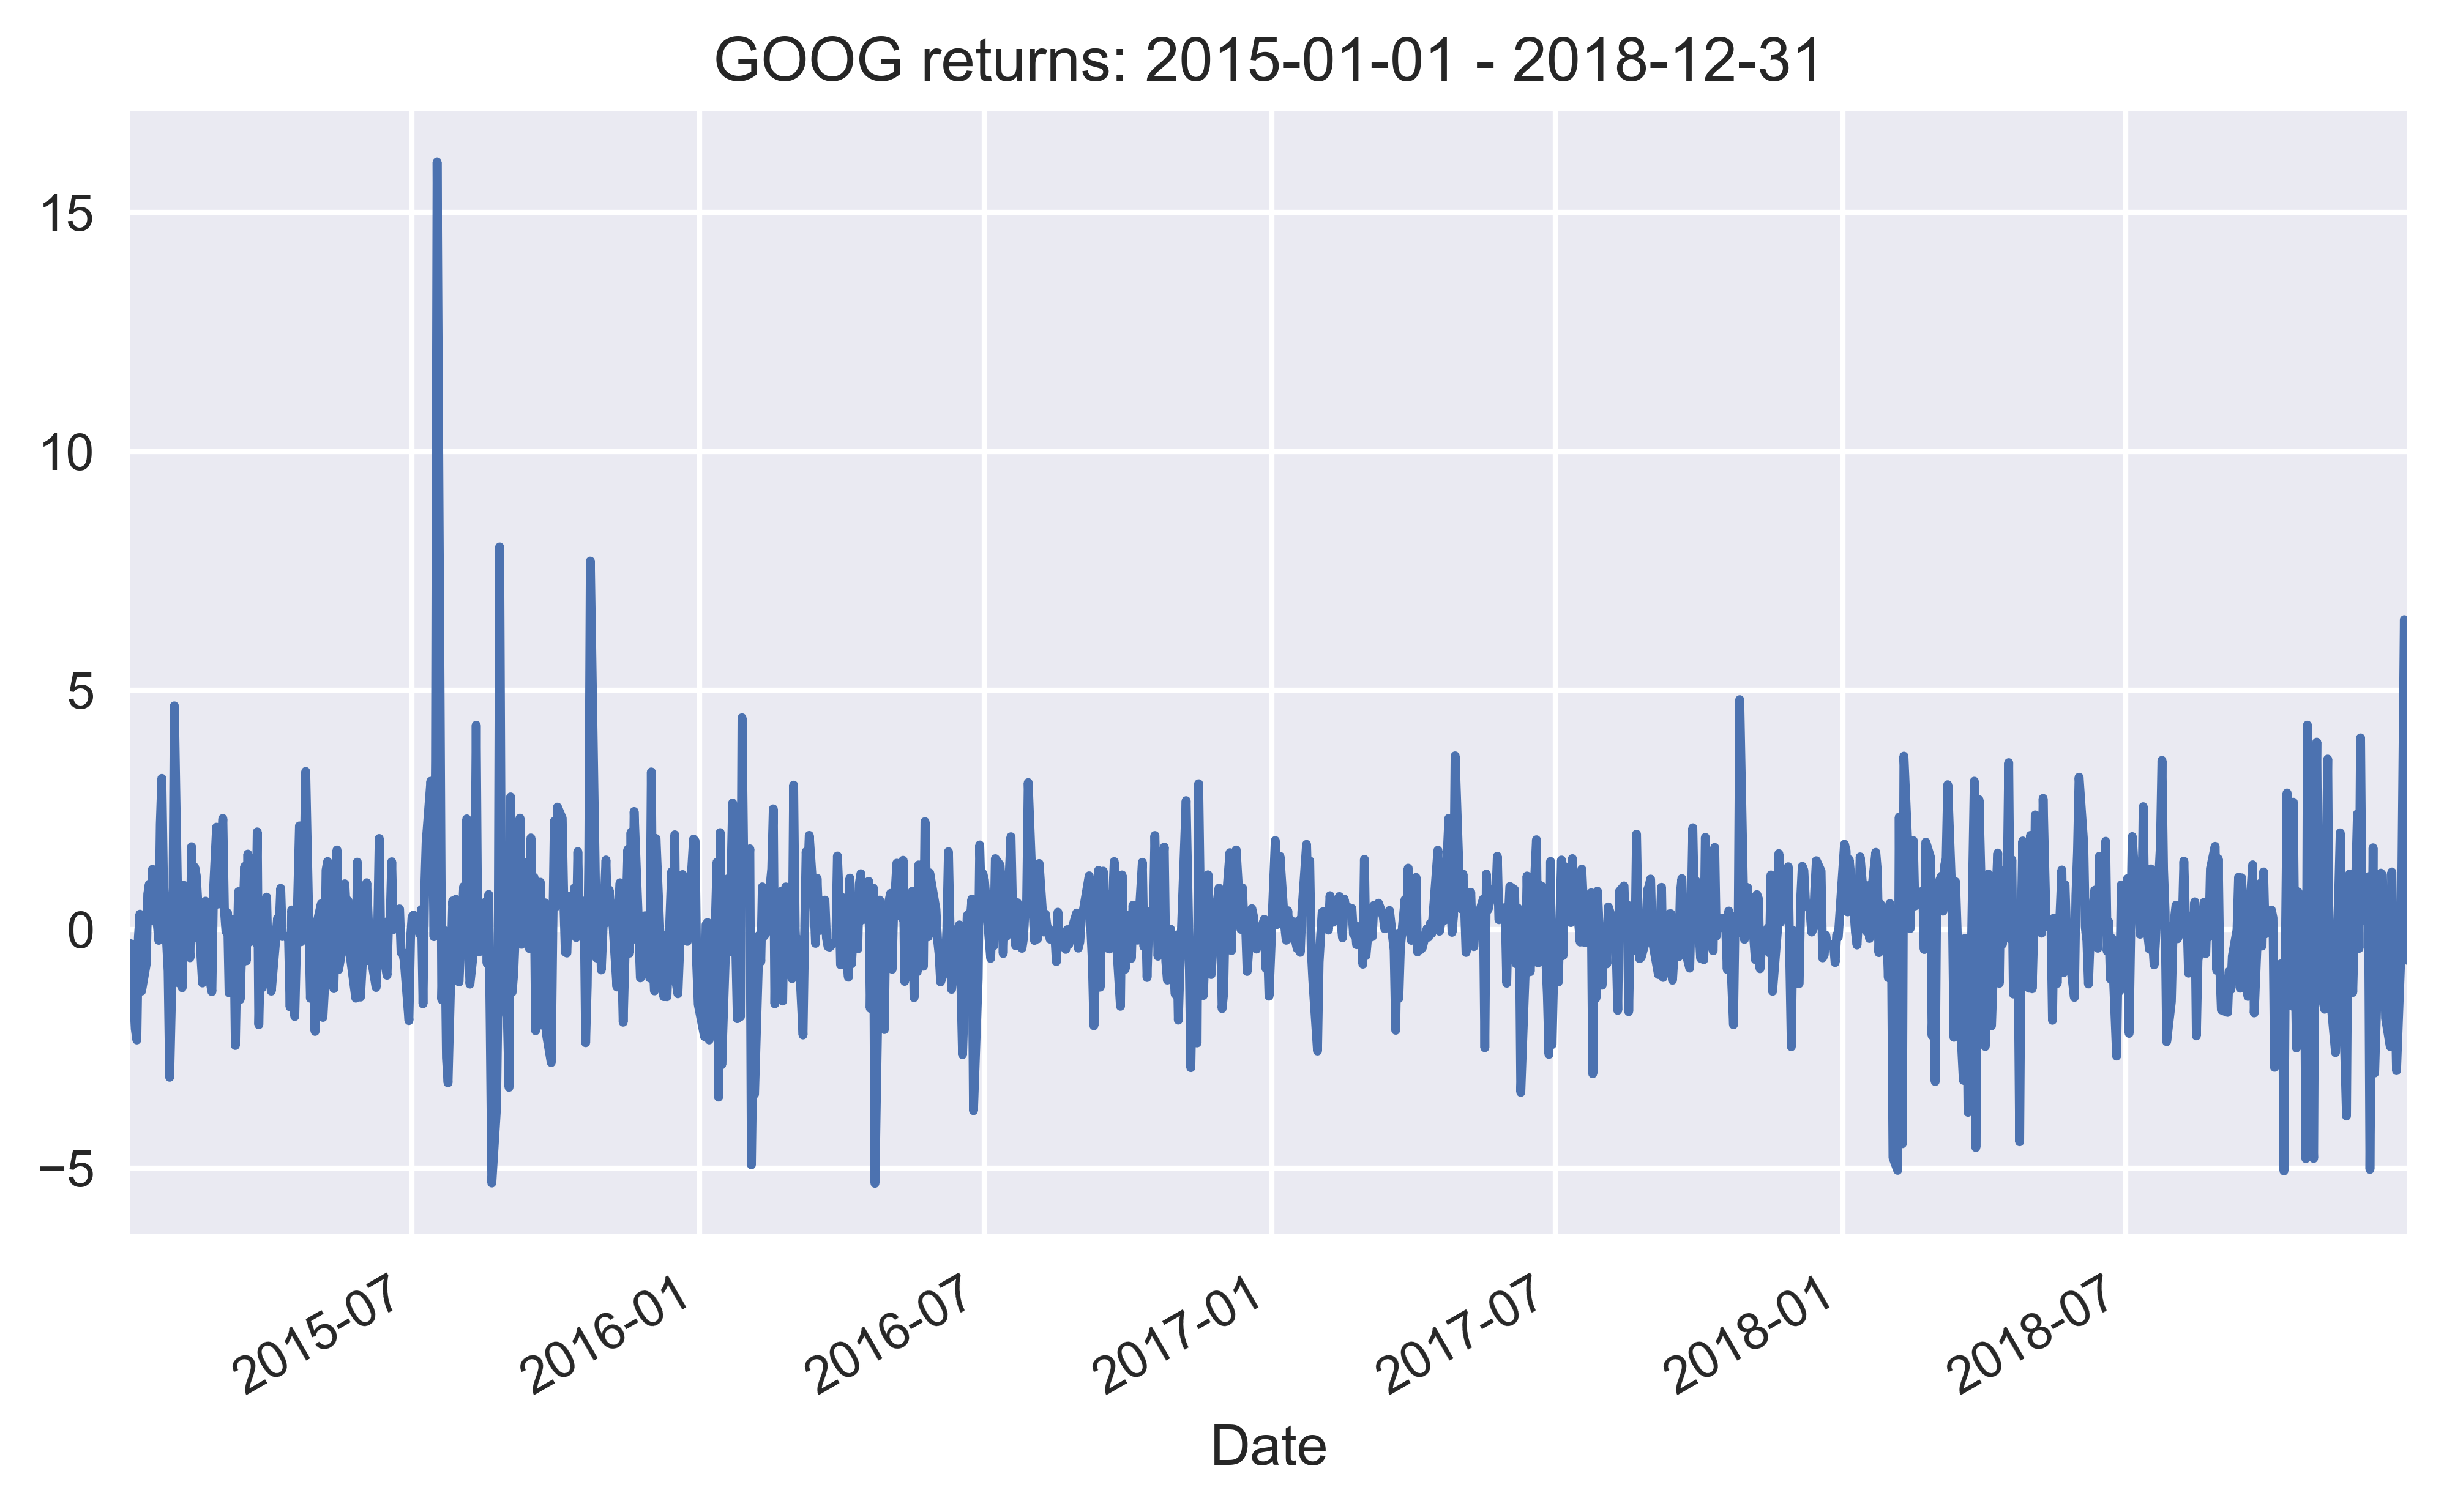

In [18]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}')

Grafikte, ani yükselmeler ve oynaklık kümelenmesi örnekleri gözlemleyebiliyoruz.

ARCH modelinin tanımlanması:

In [19]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)

Modelin tahmini ve sonuçlar:

In [20]:
model_fitted = model.fit(disp='off')
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1800.60
Distribution:                  Normal   AIC:                           3605.19
Method:            Maximum Likelihood   BIC:                           3615.02
                                        No. Observations:                 1005
Date:                Sun, Apr 12 2020   Df Residuals:                     1003
Time:                        11:01:57   Df Model:                            2
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.6323      0.167      9.794  1.193e-22   [  1.306,  1.959]
alpha[1]       0.3342      0.168      1.993  4.631e-02 [5.470e-03,  0.663]
==========================================================================

Covariance estimator: robust
"""

Hatalar ve varyansın çizdirilmesi:

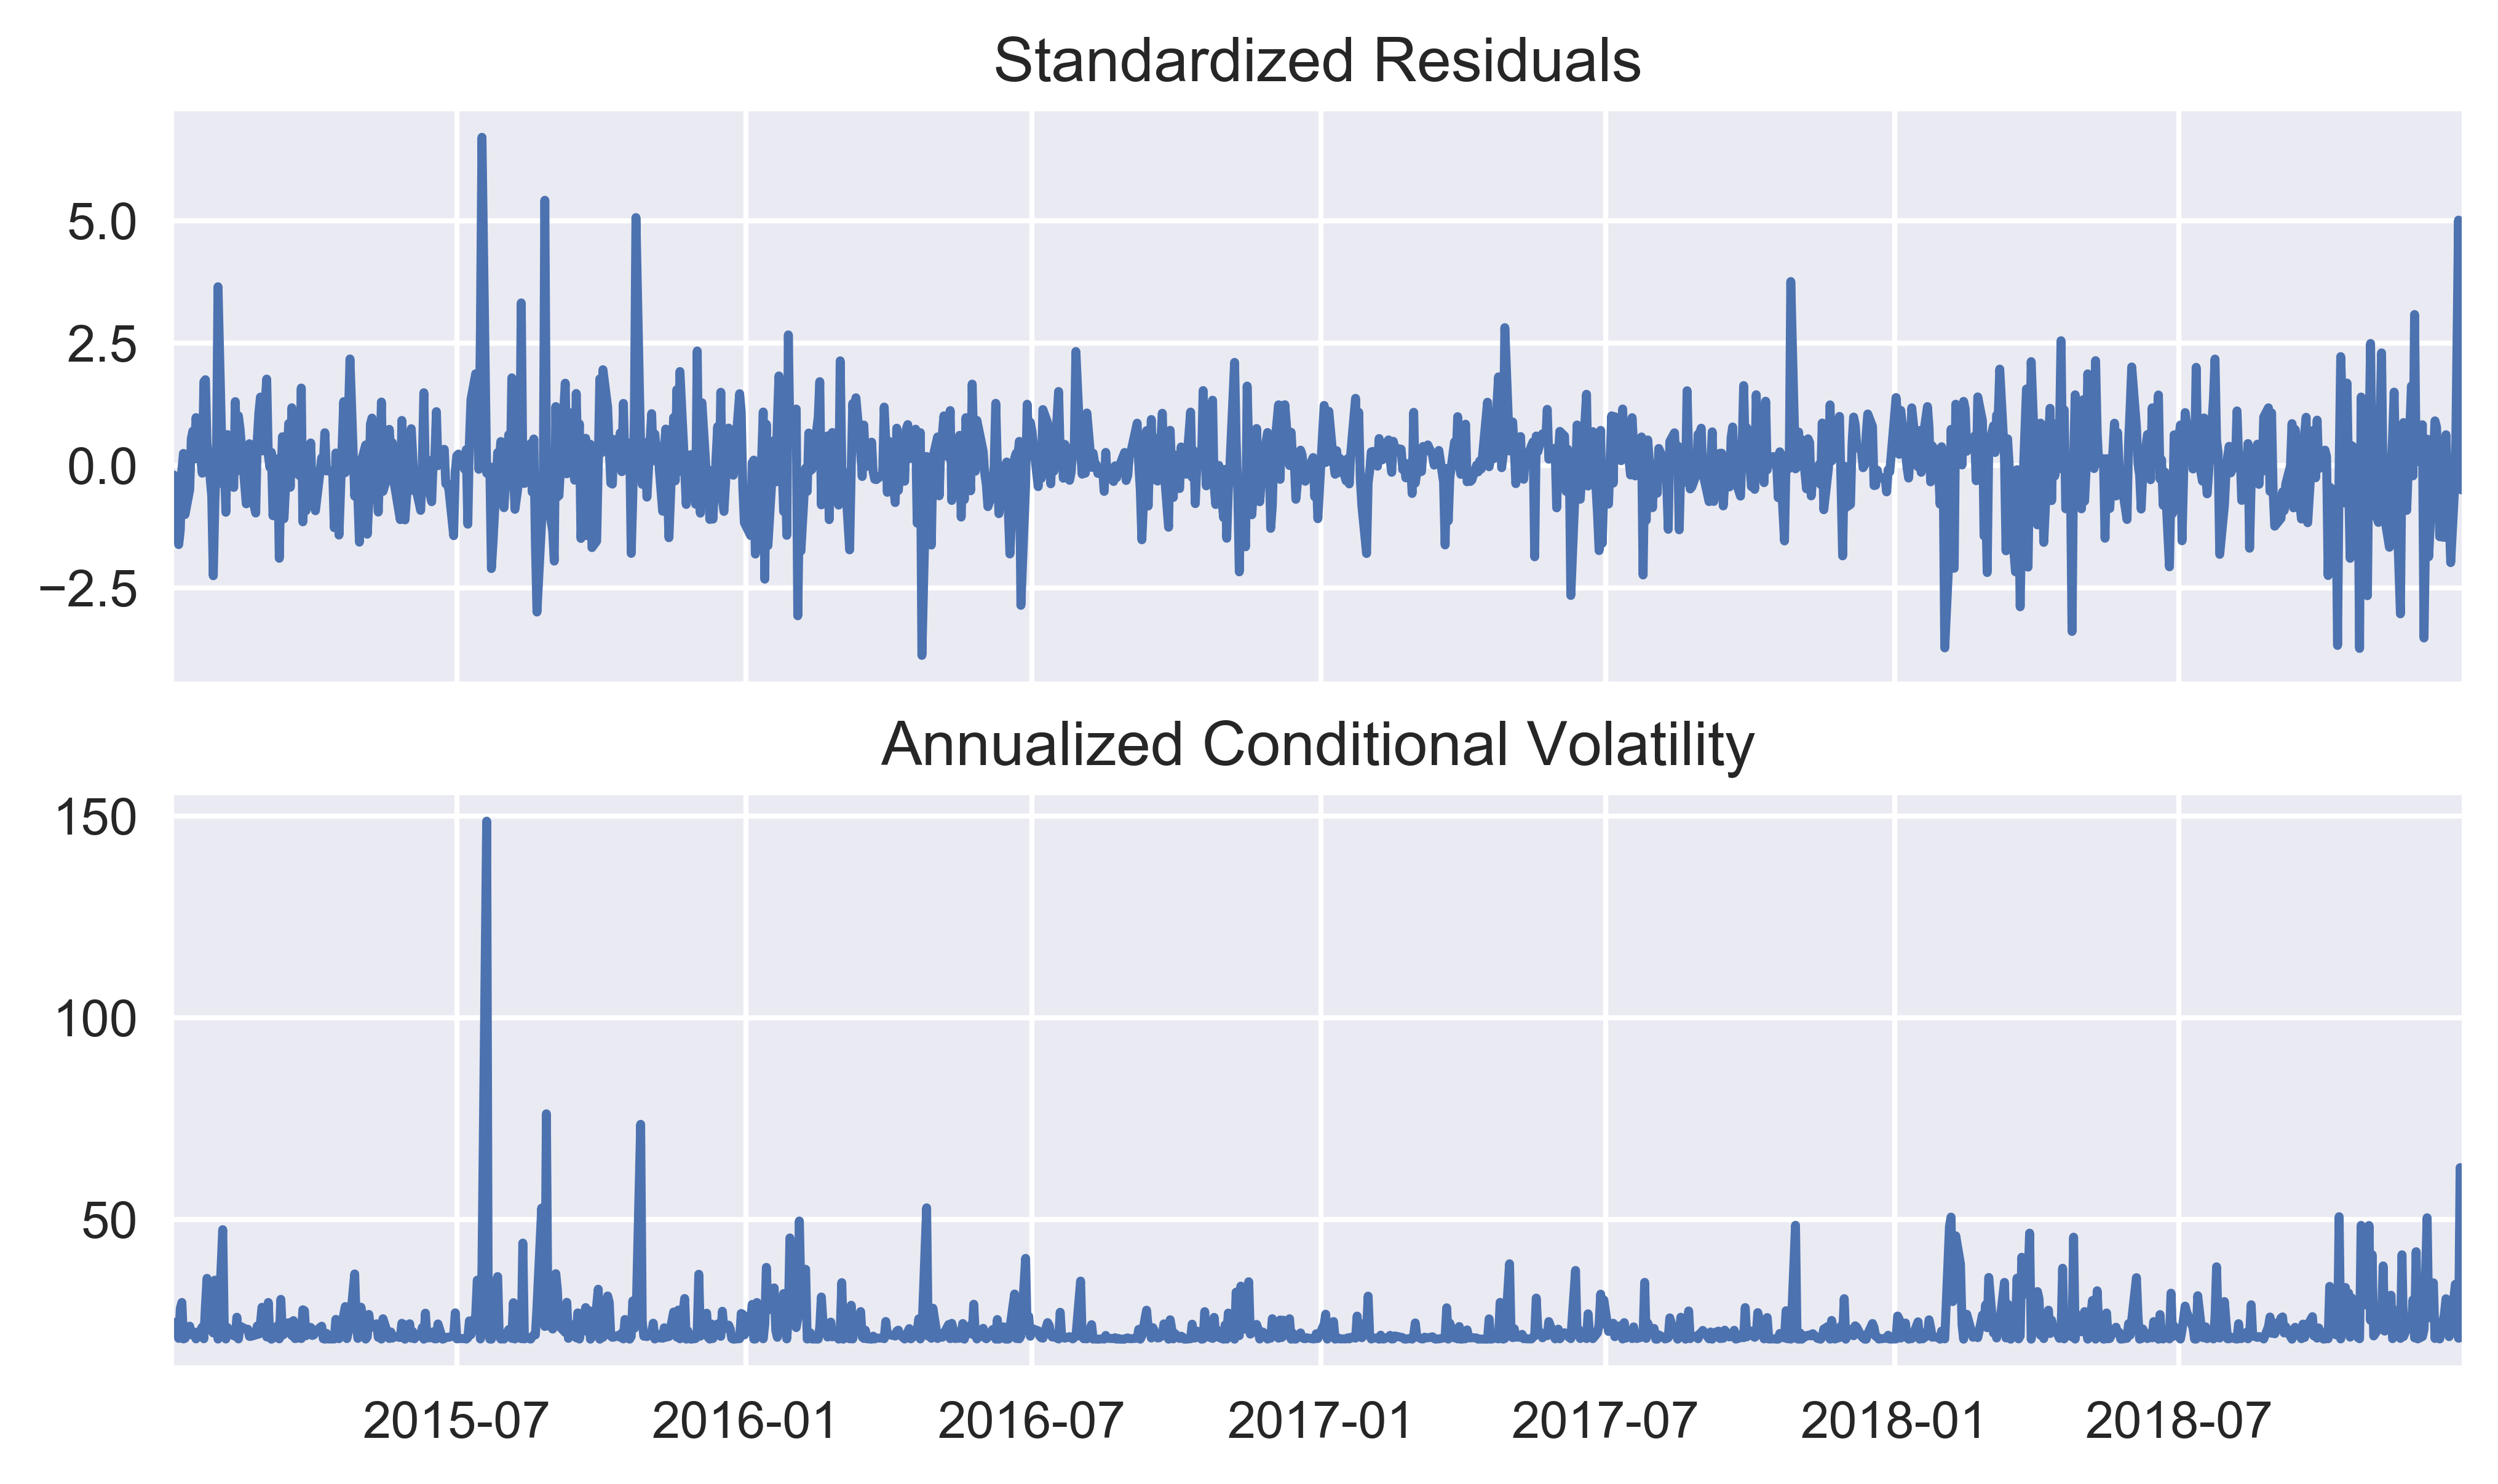

In [21]:
model_fitted.plot(annualize='D');

Büyük  ve oldukça oynaklık dönemlere karşılık gelen bazı standart kalıntıları gözlemleyebiliyoruz.

ARCH modeliyle ilgili başka noktalar:

* Sıfır ortalama sürecinin seçilmesi, ayrı olarak tahmin edilen bir modelin kalıntıları üzerinde çalışırken faydalıdır.
* ARCH etkilerini tespit etmek için, belirli bir modelden (ARIMA modeli gibi) kare artıkların korelogramına bakabiliriz. Bu artıkların ortalamasının sıfıra eşit olduğundan emin olmalıyız. Autoregressive (AR) modelinde kullanılan yaklaşıma benzer şekilde, $q$ değerini çıkarmak için Kısmi Otokorelasyon Fonksiyonu (PACF) grafiğini kullanabiliriz
* Modelin geçerliliğini test etmek için, standart artıkların ve kare standartlaşmış artıkların hiçbir seri otokorelasyon göstermediğini kontrol edebiliriz (örneğin, istatistik modellerinden Box-Pierce testi acorr_ljungbox kullanarak). Ayrıca, modelin tüm ARCH efektlerini (istatistik modellerinden het_arch) yakaladığından emin olmak için Lagrange Çarpanı (LM) testini kullanabiliriz.

# 2. Stok Getirilerinin Volatilitesinin GARCH Modelleriyle Açıklanması

Burada, ARCH modelinin bir uzantısıyla, yani Genelleştirilmiş Otoregresif Koşullu Değişen Varyans (GARCH) modeliyle nasıl çalışılacağı gösterilecektir. GARCH, bir zaman serisinin varyansına uygulanan bir ARMA modeli olarak kabul edilebilir - AR bileşeni zaten ARCH modelinde ifade edilmişken GARCH ayrıca hareketli ortalama bileşenini ekler. Başka bir deyişle, ARCH modeli koşullu varyansı geçmiş örnek varyansların doğrusal bir fonksiyonu olarak belirtirken, GARCH modeli spesifikasyona gecikmeli koşullu varyanslar ekler.

GARCH modeli eşitliği aşağıdaki gibi gösterilebilir:

$$\begin{array}{c}
r_{t}=\mu+\epsilon_{t} \\
\epsilon_{t}=\sigma_{t} z_{t} \\
\sigma_{t}^{2}=\omega+\sum_{i=1}^{q} \alpha_{i} \epsilon_{t-i}^{2}+\sum_{i=1}^{p} \beta_{i} \sigma_{t-i}^{2}
\end{array}$$

Yorum, önceki bölümde sunulan ARCH modeline çok benzemekle birlikte, fark ek bir bileşenin bulunduğu son denklemde yatmaktadır. Parametreler aşağıdakileri karşılayacak şekilde kısıtlanmıştır: $\omega>0, \alpha_{i} \geq 0,$ and $\beta_{i} \geq 0$.

GARCH modelinde katsayılar üzerinde ek kısıtlamalar bulunmaktadır. Örneğin GARCH(1,1) modelinde $\alpha_{1}+\beta_{1}$ toplamı 1'den küçük olmalıdır; aksi durumda model kararsız(unstable) olmaktadır.

GARCH modelinin iki hiperparametresi şu şekilde tanımlanabilir:

* $p$: varyans gecikme sayısı.
* $q$: ortalama sürecinden gelen hataların gecikme sayısı.

Bir GARCH (0, q) modeli bir ARCH (q) modeline eşdeğerdir.

Burada, önceki bölüme ek olarak bir GARCH(1,1) modeli gösterilecektir.

GARCH modeli tanımı:

In [22]:
model = arch_model(returns, mean='Zero', vol='GARCH', p=1, o=0, q=1)

Modelin tahmin edilip sonuçların yazılması:

In [23]:
model_fitted = model.fit(disp='off')
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1764.88
Distribution:                  Normal   AIC:                           3535.75
Method:            Maximum Likelihood   BIC:                           3550.49
                                        No. Observations:                 1005
Date:                Sun, Apr 12 2020   Df Residuals:                     1002
Time:                        11:02:12   Df Model:                            3
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1781      0.157      1.134      0.257    [ -0.130,  0.486]
alpha[1]       0.1799      0.124      1.446      0.148 [-6.393e-02,  0.424]
beta[1]        0.7616      0.153      4.991  6.012e-07    [  0.462,  1.061]
===========================================================================

Covariance estimator: robust
"""

Hataların çizdirilmesi:

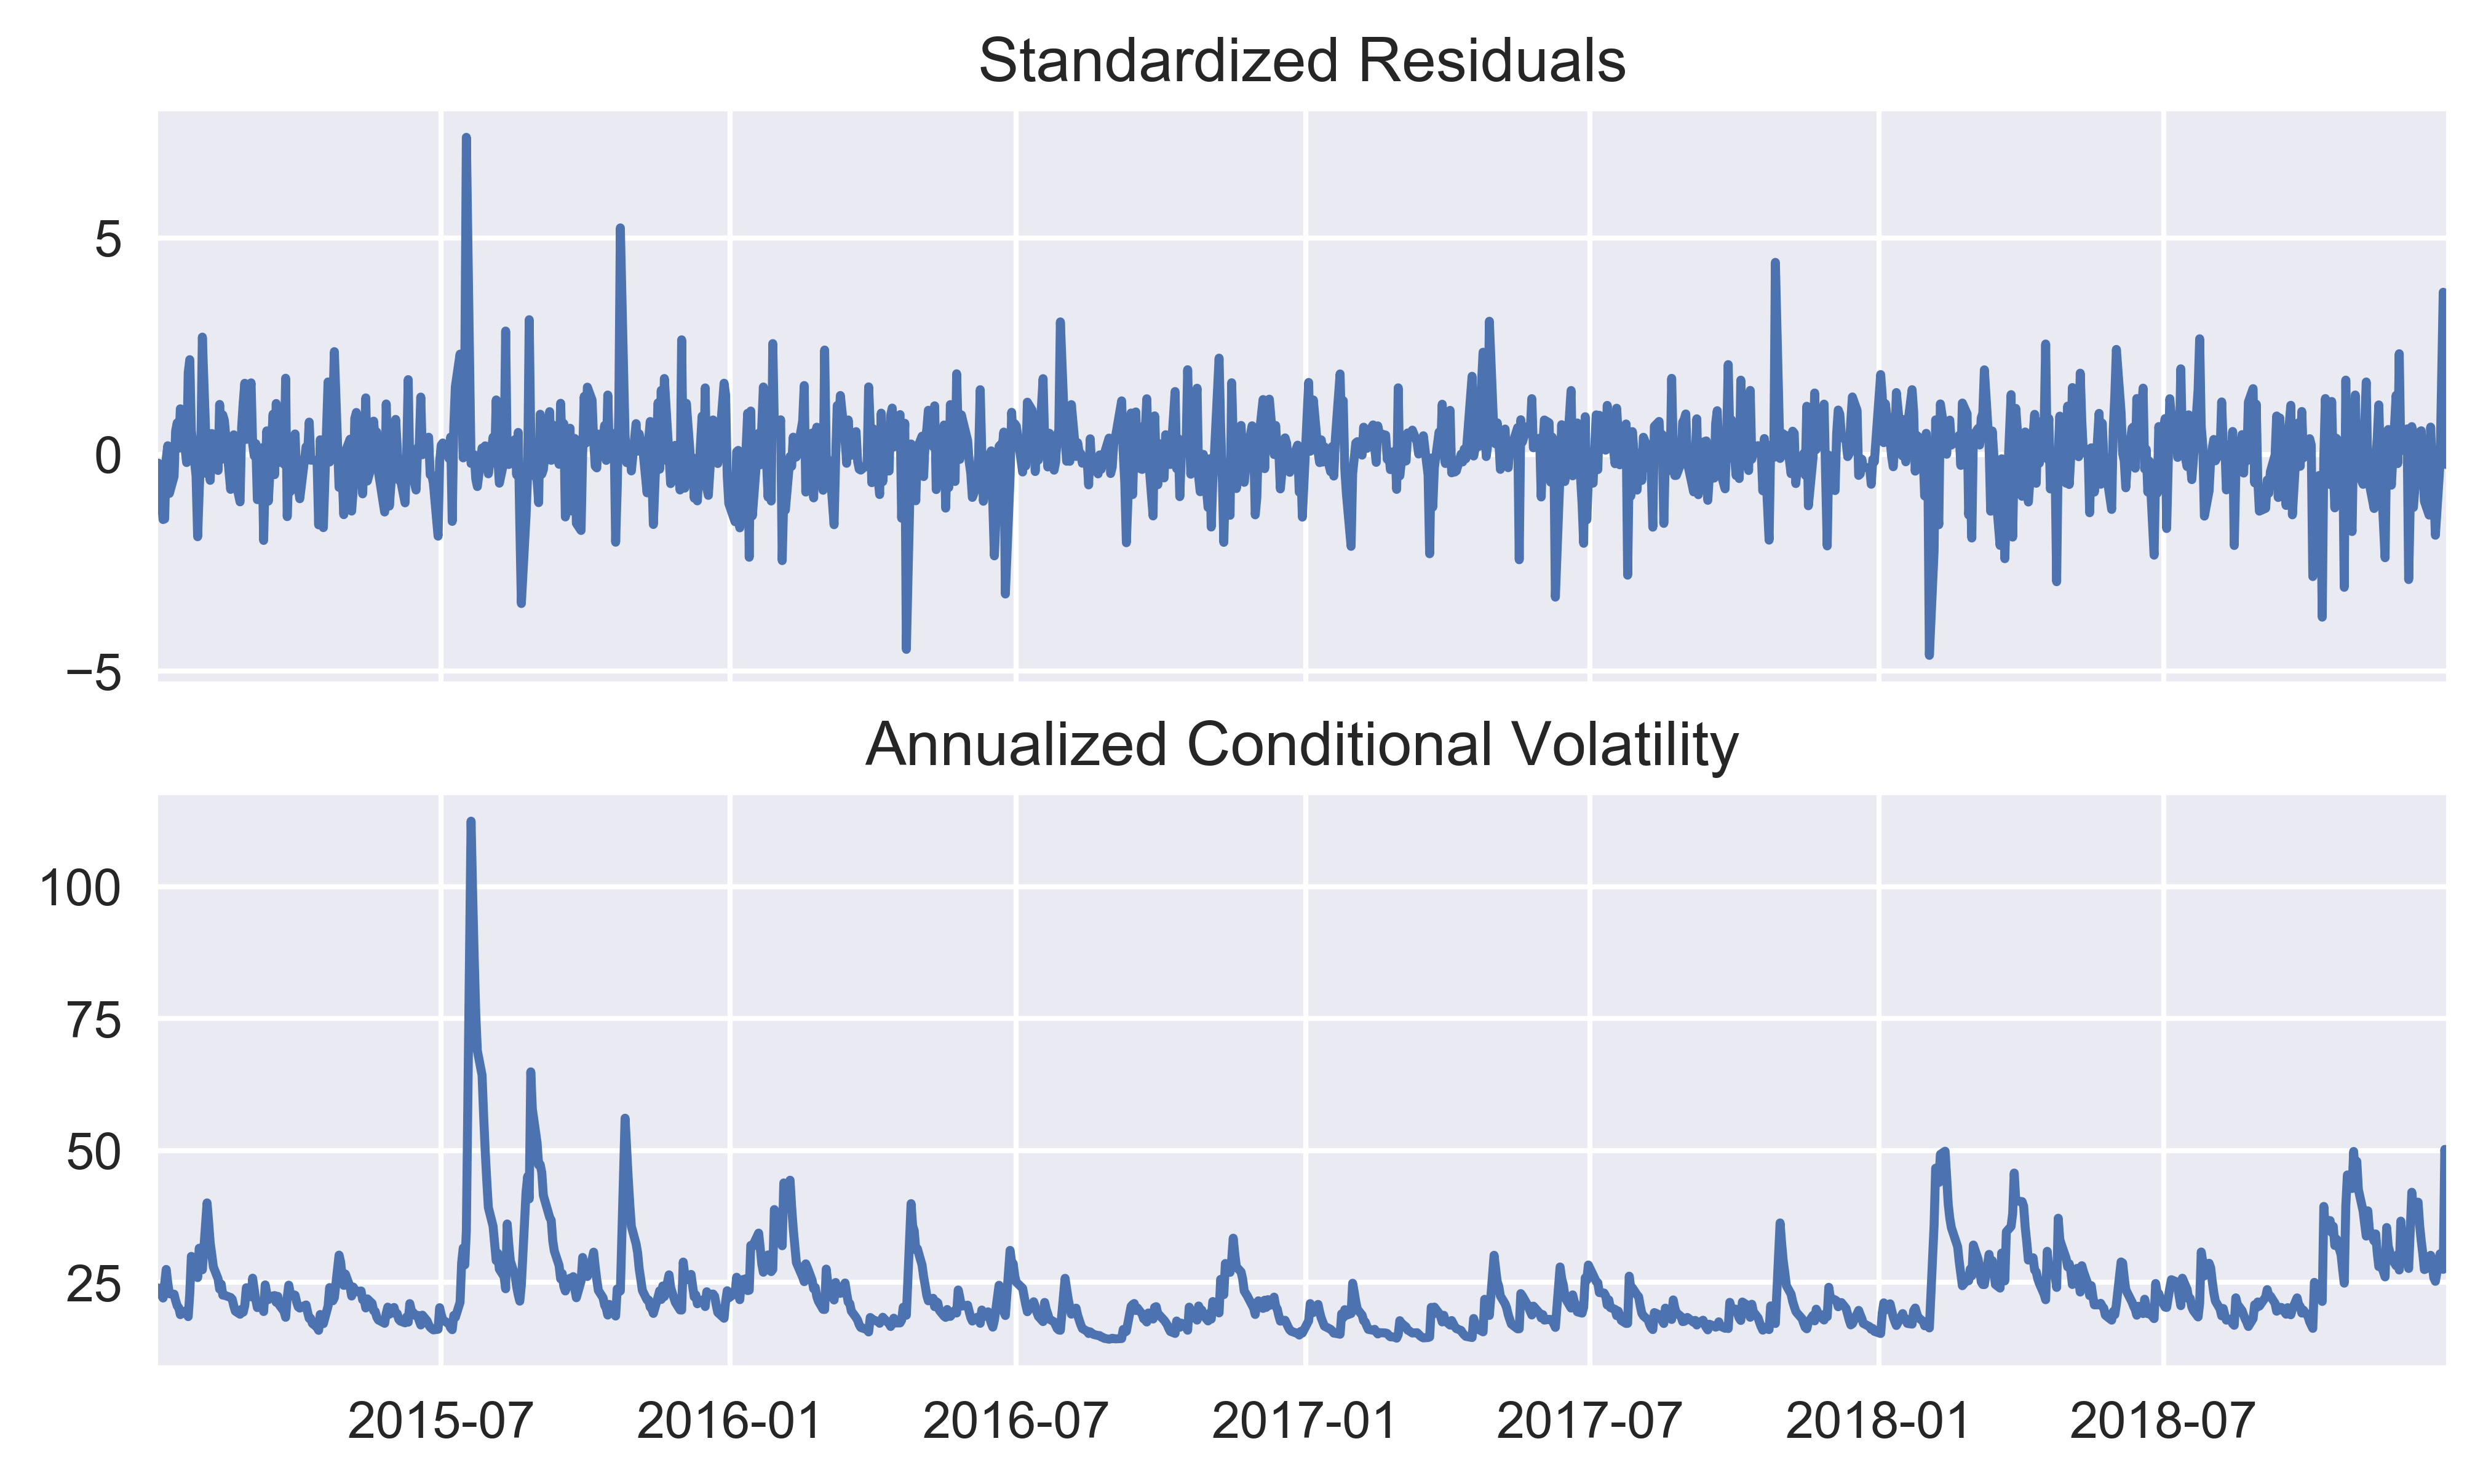

In [24]:
model_fitted.plot(annualize='D');

Grafiklerde ekstra bileşenin (gecikmeli koşullu oynaklık) model spesifikasyonuna dahil edilmesinin etkisini gözlemleyebiliriz.

ARCH kullanırken, koşullu oynaklık serisi birçok ani artış gösterir ve hemen sonra düşük seviyeye döner. GARCH durumunda, model gecikmeli koşullu oynaklığı da içerdiğinden, sivri uçtan önce gözlemlenen seviyeye geri dönmek daha fazla zaman alır.

Bununla birlikte, GARCH modelinin çok sayıda uzantısı ve en uygun modeli bulmak için deneyebileceğimiz farklı konfigürasyonlar vardır.

**Şartlı Ortalama Modeli**

Daha önce açıklandığı gibi, seriye başka bir model uygulandıktan sonra elde edilen artıklara GARCH sınıfı modelleri uyguluyoruz. Ortalama model için bazı popüler seçenekler şunlardır:

* Sıfır-ortalama
* Sabit-ortalama
* ARIMA modelinin herhangi bir varyasyonu (potansiyel mevsimsellik ayarı ve harici regresörler dahil) - literatürdeki bazı popüler seçenekler ARMA veya hatta AR modelleridir
* Regresyon modelleri

**Şartlı Volatilite Modeli**

GARCH çerçevesinin sayısız uzantısı vardır. Bazı popüler modeller şunları içerir:

* **GJR-GARCH**: Getirilerin asimetrisini dikkate alan GARCH modelinin bir varyantı (negatif getiriler, volatilite üzerinde pozitif olanlardan daha güçlü bir etkiye sahiptir)
* **EGARCH**: Üstel GARCH
* **TGARCH**: Eşik GARCH
* **FIGARCH**: Sabit olmayan verilerle kullanılan kesirli olarak entegre GARCH
* **GARCH-MIDAS**: Bu model sınıfında, oynaklık kısa bir GARCH bileşenine ve ek bir açıklayıcı değişken tarafından yönlendirilen uzun vadeli bir bileşene ayrıştırılır.
* **CCC- / DCC-GARCH** gibi çok değişkenli GARCH modelleri

İlk üç model, koşullu oynaklık spesifikasyonuna asimetri eklemek için biraz farklı yaklaşımlar kullanır. Bu, olumsuz şokların uçuculuk üzerinde pozitif şoklardan daha güçlü bir etkiye sahip olduğu inancı ile uyumludur.

**Hataların Dağılımı**

Getirilerin dağılımının Normal olmadığını gördük (eğik, ağır kuyruklu). Bu nedenle Gauss dışındaki dağılımlar GARCH modelindeki hatalara daha uygun olabilir.

Bazı olası seçenekler şunlardır:

* Student t-dağılımı
* Skew-t dağılımı (Hansen, 1994)
* Genelleştirilmiş Hata Dağıtımı (GED)
* Çarpık Genelleştirilmiş Hata Dağıtımı (SGED)

# 3. Çok Değişkenli Volatilite Tahmini İçin CCC-GARCH Modeli Uygulaması